In [3]:
import Pkg; 
# Pkg.add("FFTW")
# Pkg.add("PlotlyJS")
# Pkg.add("VectorizedRoutines")
# Pkg.add("IterTools")
# Pkg.add("Plotly")
# Pkg.add("PyPlot")
# Pkg.add("CodecZlib")

Simulation of scanning transmission electron microscopy image based on multislice solution. Thanks Mr. Zheng for the previous advice.

In [2]:
using FFTW
using JSON
using LinearAlgebra
using NPZ
using Combinatorics
using .GC
using IterTools
using PyPlot
using Base.Threads
using JLD2
using CodecZlib
using Base.Filesystem
println(Threads.nthreads())

function meshgrid(x, y)
    return repeat(x, 1, length(y))', repeat(y, 1, length(x))
end

54


meshgrid (generic function with 1 method)

In [4]:
struct hyperparams 
    coarse_step::Int64
    nz::Int64
    nx_simu::Int64
    ny_simu::Int64
    hbar::Float64
    v::Float64 #* electron velocity
    dz_list::Vector{Float64} #* slice thickness list
    λ::Float64 #* wavelength
    potential_slices::Array{Float64, 3}
    lattice_param::Vector{Float64} #* lattice parameter
    objective_angle::Float64 #* objective collection angle
    sav_pth::String
    # σe::Float64 #* electron interaction parameter
    Cs::Float64 #* spherical aberration coefficient
    Δf::Float64 #* defocus
    repeat_cell::Vector{Float64} #* cell dimension
end

function init_freq(l, n)
    return collect(LinRange(-n/(2l), n/(2l), n))
end

function fft_custom(r_list, int_list, kpt_list, kmap_size)
    k_int = sum(int_list.*exp.(-2*im*π*(kpt_list*r_list')), dims=2)
    kpt_map = reshape(k_int, kmap_size, kmap_size)
    return kpt_map
end

function ifft_custom(r_list, kpt_map, k_range, kmap_size, nx, ny)

    k_input = collect(LinRange(-k_range, k_range, kmap_size))
    kpt_list = collect(product(k_input, k_input))
    int_list = sum(kpt_map.*exp.(2*im*π*(kpt_list*r_list')), dims=1)/(kmap_size^2)
    int_map = reshape(int_list, nx, ny)
    return int_map
end

function σe_derive(acc_V, λ)
    e0 = 510998.9461 #* electron rest mass, eV
    return 2π /(λ*acc_V) * (e0 + acc_V) / (2*e0 + acc_V)
end

function element_translate(shift_vec::Vector{Int64}, x)
    x_trans = zeros(size(x))
    x_trans = ComplexF64.(x_trans)
    nx, ny = size(x)
    for i in 1:nx
        for j in 1:ny
            i_n = ifelse((i+shift_vec[1])%nx == 0, nx, abs((i+shift_vec[1])%nx))
            j_n = ifelse((j+shift_vec[2])%ny == 0, ny, abs((j+shift_vec[2])%ny))
            x_trans[i_n, j_n] = x[i,j]
        end 
    end 
    return x_trans
end 

function χk(λ, qx, qy, Δf, Cs)
    return π*λ.*(qx.^2 .+ qy.^2).*(-Δf .+ 1/2*Cs*(qx.^2 .+ qy.^2)*λ^2)
end

function main_simu(params::hyperparams)
    coarse_step = params.coarse_step
    nz = params.nz
    nx_simu, ny_simu = params.nx_simu, params.ny_simu
    repeat_cell = params.repeat_cell
    dz_list, λ, v = params.dz_list, params.λ, params.v
    potential_slices = params.potential_slices
    lattice_param = params.lattice_param
    objective_angle_max = params.objective_angle
    sav_pth_psi = params.sav_pth
    Cs, Δf = params.Cs, params.Δf

    println("initialize frequency grid in reciprocal space...")

    #* initialize frequency grid in reciprocal space
    lp_x, lp_y = lattice_param[1], lattice_param[2]
    ds = (lp_x*lp_y)/(nx_simu*ny_simu)
    qx_true = fftshift(fftfreq(nx_simu, nx_simu/lp_x))
    qy_true = fftshift(fftfreq(ny_simu, ny_simu/lp_y))
    # qx_true = fftshift(fftfreq(nx_simu))
    # qy_true = fftshift(fftfreq(ny_simu))
    qx_true, qy_true = meshgrid(qx_true, qy_true)
    q2_true = qx_true.^2 .+ qy_true.^2
    bandwidth_limit_true = 2/3*(minimum([maximum(abs.(qx_true)), maximum(abs.(qy_true))]))
    q_xy_norm = sqrt.(qx_true.^2 .+ qy_true.^2)

    #* k-mesh in julia FFT, only for computing
    qx = fftshift(fftfreq(nx_simu))
    qy = fftshift(fftfreq(ny_simu))
    #* bandwidth limit of transmission function to 2/3 max |k|
    bandwidth_limit = 2/3*(minimum([maximum(abs.(qx)), maximum(abs.(qy))]))
    qx, qy = meshgrid(qx, qy)
    q2 = qx.^2 .+ qy.^2
    q_norm = sqrt.(q2)
    q_bandwidth_filter = ifelse.(q_norm .<= bandwidth_limit, 1, 0)

    #* objective aperture function
    q_obj = ifelse.(q_xy_norm*λ .<= objective_angle_max, 1, 0)

    #* annular detector function
    #TODO multi-annular detector
    θ_list = collect(10e-3:2e-3:60e-3)
    # append!(θ_list, [51e-3, 68e-3])
    q_annu_list = [ifelse.(q_xy_norm*λ .<= 220e-3 
        .&& q_xy_norm*λ .>= θ 
        .&& q_norm .<= 1/2, 1, 0) for θ in θ_list]
    abf_annu = ifelse.(q_xy_norm*λ .<= 6e-3, 1, 0)
    # q_annu = ifelse.(q_xy_norm*λ .<= 280e-3 .&& q_xy_norm*λ .>= 68e-3 .&& q_norm .<= 1/2, 1, 0)

    #* absorptive potential (when considering TDS)
    v_ha_term = 1 
    
    println("done\n initialize transmitting function...")

    #* initialize transmitting function (0 K), assume that potential is already integrated along optical axis z
    potential_slices = (potential_slices)
    potential_slices = ComplexF64.(potential_slices)

    for i in 1:nz
        pot_fft = fftshift(fft(potential_slices[:,:,i]))
        pot_ifft = (ifft(ifftshift(pot_fft.*q_bandwidth_filter)))
        potential_slices[:,:,i] .= (pot_ifft)
    end
    #TODO phase grating for potential slices
    # phase_gratings = [exp.(-im/(hbar*v).*potential_slices[:,:,i]).*v_ha_term for i in 1:nz] #* Ishizuka
    phase_gratings = [exp.(im*σe_derive(200e3, λ) .* potential_slices[:,:,i]) for i in 1:nz] #* Kirkland

    #TODO bandwidth limit of transmission function to 2/3 max |k|
    for i in 1:nz
        pg_fft = fftshift(fft(phase_gratings[i]))
        pg_ifft = (ifft(ifftshift(pg_fft.*q_bandwidth_filter)))
        phase_gratings[i] = pg_ifft
    end
    
    #* initialize gray scale stem_image
    nx_img, ny_img = Int64(floor(nx_simu/repeat_cell[1])), Int64(floor(ny_simu/repeat_cell[2]))
    nx_coarse, ny_coarse = Int64(floor(nx_img/coarse_step)), Int64(floor(ny_img/coarse_step))
    #TODO multi-annular detector
    haadf_img = zeros(Float64, nx_coarse, ny_coarse, length(θ_list))
    abf_img = zeros(Float64, nx_coarse, ny_coarse)

    lx_buffer = fftshift(fftfreq(nx_simu, lp_x))
    ly_buffer = fftshift(fftfreq(ny_simu, lp_y))
    # lx_buffer = fftshift(fftfreq(nx_simu, nx_simu))
    # ly_buffer = fftshift(fftfreq(ny_simu, ny_simu))
    rx, ry = meshgrid(lx_buffer, ly_buffer)
    
    #* real-space fractional coordinates
    ind_x_buffer, ind_y_buffer = collect(1:nx_coarse), collect(1:ny_coarse)
    ind_x_buffer_true, ind_y_buffer_true = collect(1:coarse_step:nx_img), collect(1:coarse_step:ny_img)

    println("done\n initialize propagator function...")
    println("coarse dimension: $(nx_coarse)×$(ny_coarse)×$(nz)")
    
    #* propagator function as list (for each slice) 
    # ! which frequency grid to use? (no difference at all, from principles of DFT and FFT)
    prop_list = [exp.(-im*π*dz*λ.*(q2_true)).*q_bandwidth_filter for dz in dz_list]

    println("done\n start multislice simulation on STEM images...")

    ind_prod = collect(product(ind_x_buffer, ind_y_buffer))
    # int_list = zeros(Float64, length(ind_prod), nz) # store each slice's information
    # psi_xy_finlist = zeros(ComplexF64, nx_simu, ny_simu, nx_coarse*ny_coarse)
    psi_xy_finlist = 0
    Threads.@threads for (ix, iy) in ind_prod
        
        ix_true, iy_true = ind_x_buffer_true[ix], ind_y_buffer_true[iy]
        lx, ly = rx[ix_true, iy_true], ry[ix_true, iy_true]
        ind_grid = (iy-1)*nx_coarse + ix

        #* initialize wavefunction as incident beam
        #TODO under testing, use with caution
        χk_ = nothing
        if Δf == 0 && Cs == 0
            χk_ = 0
        else 
            χk_ = χk(λ, qx_true, qy_true, Δf, Cs)
        end

        psi_xy = ifftshift(ifft(fftshift(exp.(-2π*im*(qx_true.*lx .+ qy_true.*ly) .- im.*χk_).*q_obj)))
        
        #! change normalization condition?
        norm_factor = sum(abs.(psi_xy).^2)*ds
        psi_xy = psi_xy./norm_factor

        for phase_i in 1:nz

            phase_grating = phase_gratings[phase_i]
            prop = (prop_list[phase_i])
            psi_singlept = phase_grating.*psi_xy #* apply phase grating
            #! fftshift? conj or not?
            psi_xy = (ifft(ifftshift(conj.(prop).*fftshift(fft(psi_singlept)))))
            # int_list[ind_grid, phase_i] = sum(abs.(psi_xy).^2)
            # psi_xy = psi_xy./sum(abs.(psi_xy).^2)
        end
        
        #* filter on Annular detector (68~280 mrad)
        # psi_xy_finlist[:,:,ind_grid] = psi_xy
        # int_xy = sum([abs(sum(annu_mat[:,:,i] .* psi_xy))^2 for i in 1:len_annu])
        #TODO change filepath
        # save("$(sav_pth_psi)/psi_$(ix)_$(iy).jld2", "ψ", psi_xy)

        psi_xy_fft = fftshift(fft(psi_xy))
        for (q_i, q_annu) in enumerate(q_annu_list)
            psi_xy_k = psi_xy_fft.*q_annu
            int_xy = sum(abs.(psi_xy_k).^2)

            haadf_img[ix, iy, q_i] = int_xy
        end
        abf_img[ix, iy] = sum(abs.(psi_xy_fft .* abf_annu).^2)

        #TODO single annular detector?
        # psi_xy_k = fftshift(fft(psi_xy)).*q_annu
        # int_xy = sum(abs.(psi_xy_k).^2)
        # stem_image[ix, iy] = int_xy

        if ind_grid % 10000 == 0
            println("$(ind_grid)/$(nx_coarse*ny_coarse) finished")
            GC.gc()
        end
    end

    return haadf_img, abf_img, psi_xy_finlist
end

v = 2.0844e+18 #* relativistic electron velocity at 200 keV, Å/s
hbar = 6.582119569e-16 #* reduced Planck constant, eV*s
m0 = 0.91094e-30 #* electron mass, kg
m = 1.2674e-30 #* relativistic mass, kg
e = 1.602176634e-19 #* elementary charge, C
λ = 0.02508  #* Electron wavelength, Å
Cs = 0 #* Spherical abberation, Å
objective_angle = 22e-3 #* objective collection angle, rad
Δf = 0 #* Defocus, Å
stack_sequence = 3

lp_z = 7.67954 #* lattice parameter, Å, for one slice
coarse_step = 2 #TODO coarsen image size
repeat_cell = [2.,3.] #TODO dimension of repeated cell
# lattice_param = [10.0098*repeat_cell[1], 29.7250*repeat_cell[2]] #* lattice parameter, Å, for one slice
lattice_param = [29.725*repeat_cell[1], 19.27832*repeat_cell[2]] #* lattice parameter, Å, for one slice
# slice_calc = 32

#* load atomic form factor 
# form_json = JSON.parsefile("form_factor.json")

#* load potential slices
pth_base = ""
#TODO if debug: select a few slices
potential_slices = npzread("$(pth_base)/pot_bulk_up800_vert8_merge2_3_X.npy") #* assume that potential is already integrated along axis z
dz_list = npzread("$(pth_base)/pot_bulk_up800_vert8_merge2_3_dz.npy")

nx_simu, ny_simu = size(potential_slices, 1), size(potential_slices, 2)  #* real-space grid size
nz = length(dz_list)

potential_slices = potential_slices #TODO make sure the potential near nucleus is positive
potential_slices = potential_slices .- minimum(potential_slices)
# potential_slices = -potential_slices[:,:,1:coarse_slice:180-pbc_cutoff]
potential_slices = repeat(potential_slices, outer=[1, 1, stack_sequence])
dz_list = repeat(dz_list, outer=[stack_sequence])

nz = nz*stack_sequence
params = hyperparams(coarse_step, nz, nx_simu, ny_simu, 
                    hbar, v, dz_list, 
                    λ, potential_slices, lattice_param, objective_angle, 
                    "", Cs, Δf, repeat_cell,)
# println("save to $(sav_pth)\n")

#TODO RESTART Kernel before running (to reload variables and free memory)
run_ = false
stem_image = nothing
if run_
    println("input configuration: $(nx_simu)×$(ny_simu)×$(nz) grids")
    println("specimen thickness: $(lp_z*stack_sequence/10) nm")
    stem_image = main_simu(params)
end

GC.gc()

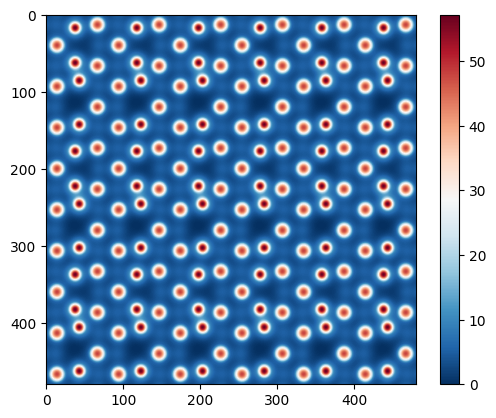

PyObject <matplotlib.colorbar.Colorbar object at 0x2b10d2b626e0>

In [147]:
imshow(potential_slices[:,:,1], cmap="RdBu_r")
colorbar()

0.014


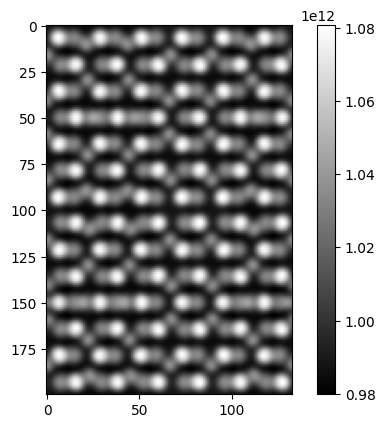

PyObject <matplotlib.colorbar.Colorbar object at 0x2acea87cb6a0>

In [21]:
#* without `fftshift`
end_image = stem_image[1]
θ_list = collect(10e-3:2e-3:60e-3)
# append!(θ_list, [51e-3, 68e-3])

select_ind = 3
imshow(end_image[:,:,select_ind], cmap="gray")
println(θ_list[select_ind])
colorbar()